<a href="https://colab.research.google.com/github/frankblue10/TFM_CUANTICA/blob/main/Pruebas/TFM_Pruebas_algoritmos_y_comparaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalamos Pennylane
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 38.0 MB/s eta 0:00:00


Iteración 01 - Precisión: 0.66
Iteración 02 - Precisión: 0.84
Iteración 03 - Precisión: 0.83
Iteración 04 - Precisión: 0.70
Iteración 05 - Precisión: 0.74
Iteración 06 - Precisión: 0.81
Iteración 07 - Precisión: 0.61
Iteración 08 - Precisión: 0.76
Iteración 09 - Precisión: 0.64
Iteración 10 - Precisión: 0.80
Iteración 11 - Precisión: 0.84
Iteración 12 - Precisión: 0.86
Iteración 13 - Precisión: 0.84
Iteración 14 - Precisión: 0.71
Iteración 15 - Precisión: 0.60
Iteración 16 - Precisión: 0.86
Iteración 17 - Precisión: 0.86
Iteración 18 - Precisión: 0.83
Iteración 19 - Precisión: 0.64
Iteración 20 - Precisión: 0.83
Iteración 21 - Precisión: 0.70
Iteración 22 - Precisión: 0.86
Iteración 23 - Precisión: 0.64
Iteración 24 - Precisión: 0.66
Iteración 25 - Precisión: 0.83
Iteración 26 - Precisión: 0.66
Iteración 27 - Precisión: 0.83
Iteración 28 - Precisión: 0.83
Iteración 29 - Precisión: 0.77
Iteración 30 - Precisión: 0.84

🔍 Precisión en prueba: 0.83


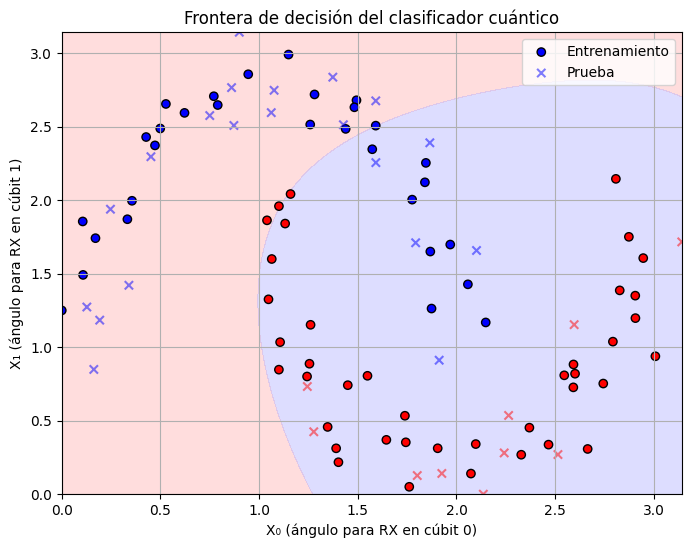

In [5]:
#Prueba de cómo un clasificador cuántico(VQC) con 2 cúbits,
#puede aprender una frontera de decisión no lineal en base
#a un ansatz profundo y entrelazamiento.
####------------------------------------------###
# Importación de bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer

# Generación de datos tipo "moons" para clasificación binaria
entradas, etiquetas = make_moons(n_samples=100, noise=0.1, random_state=42)

# Escalado de las características al rango [0, π]
escalador = MinMaxScaler(feature_range=(0, np.pi))
entradas_escaladas = escalador.fit_transform(entradas)

# División del conjunto en entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    entradas_escaladas, etiquetas, test_size=0.3, random_state=42
)

# Configuración del dispositivo cuántico y número de cúbits
n_cubits = 2
dispositivo = qml.device("default.qubit", wires=n_cubits)

#---------VQC---------------------------------------------
# Codificación angular de las entradas clásicas:preparación del estado de entrada del VQC.

def codificar(entrada):
    for i in range(n_cubits):
        qml.RX(entrada[i], wires=i)

# Definición del ansatz variacional para VQC.
def ansatz(parametros):
    n_capas = parametros.shape[0]
    for capa in range(n_capas):
        for i in range(n_cubits):
            qml.RY(parametros[capa, i], wires=i)
        qml.CNOT(wires=[0, 1])

# Circuito cuántico completo: inferencia para VQC
@qml.qnode(dispositivo)
def circuito(entrada, parametros):
    codificar(entrada)
    ansatz(parametros)
    return qml.expval(qml.PauliZ(0))  # Medición del cúbit 0


# Función para predecir etiquetas con el circuito cuántico
def predecir(entradas, parametros):
    return [np.sign(circuito(x, parametros)) for x in entradas]

# Inicialización de parámetros variacionales
np.random.seed(42)
n_capas = 3
parametros = qml.numpy.array(
    np.random.uniform(0, np.pi, size=(n_capas, n_cubits)),
    requires_grad=True
)

# Conversión de etiquetas {0,1} a {-1,1} para la función de coste
etiquetas_entrenamiento_mod = 2 * y_entrenamiento - 1

# Configuración del optimizador y número de épocas
optimizador = NesterovMomentumOptimizer(stepsize=0.2)
iteraciones = 30

# Proceso de entrenamiento
for iteracion_global in range(iteraciones):
    for entrada, etiqueta_objetivo in zip(X_entrenamiento, etiquetas_entrenamiento_mod):
        def funcion_perdida(p):
            return (circuito(entrada, p) - etiqueta_objetivo) ** 2
        parametros = optimizador.step(funcion_perdida, parametros) #Entrenamiento de circuito usando #NesterovMomentumOptimizer#

    predicciones = predecir(X_entrenamiento, parametros)
    precision = accuracy_score(etiquetas_entrenamiento_mod, predicciones)
    print(f"Iteración {iteracion_global+1:02d} - Precisión: {precision:.2f}")

# Evaluación del modelo sobre el conjunto de prueba
etiquetas_prueba_mod = 2 * y_prueba - 1
predicciones_prueba = predecir(X_prueba, parametros)
precision_prueba = accuracy_score(etiquetas_prueba_mod, predicciones_prueba)
print(f"\n🔍 Precisión en prueba: {precision_prueba:.2f}")


# Generación de una malla de puntos para representar la frontera de decisión
xx, yy = np.meshgrid(
    np.linspace(0, np.pi, 100),
    np.linspace(0, np.pi, 100)
)

# Evaluación del modelo cuántico sobre cada punto de la malla
puntos_malla = np.c_[xx.ravel(), yy.ravel()]
Z = [circuito(x, parametros) for x in puntos_malla]
Z = np.array(Z).reshape(xx.shape)

# Creación del gráfico de decisión
plt.figure(figsize=(8, 6))

# Dibujamos la frontera de decisión
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.4)

# Puntos de entrenamiento
plt.scatter(X_entrenamiento[:, 0], X_entrenamiento[:, 1], c=y_entrenamiento,
            cmap='bwr', edgecolors='k', label="Entrenamiento")

# Puntos de prueba
plt.scatter(X_prueba[:, 0], X_prueba[:, 1], c=y_prueba,
            cmap='bwr', alpha=0.5, marker='x', label="Prueba")

plt.title("Frontera de decisión del clasificador cuántico")
plt.xlabel("X₀ (ángulo para RX en cúbit 0)")
plt.ylabel("X₁ (ángulo para RX en cúbit 1)")
plt.legend()
plt.grid(True)
plt.show()



Iteración 01 - Precisión: 0.12
Iteración 02 - Precisión: 0.25
Iteración 03 - Precisión: 0.25
Iteración 04 - Precisión: 0.50
Iteración 05 - Precisión: 0.62
Iteración 06 - Precisión: 0.88
Iteración 07 - Precisión: 0.50
Iteración 08 - Precisión: 0.75
Iteración 09 - Precisión: 0.62
Iteración 10 - Precisión: 0.50
Iteración 11 - Precisión: 0.62
Iteración 12 - Precisión: 0.50
Iteración 13 - Precisión: 0.62
Iteración 14 - Precisión: 0.50
Iteración 15 - Precisión: 0.62
Iteración 16 - Precisión: 0.62
Iteración 17 - Precisión: 0.62
Iteración 18 - Precisión: 0.62
Iteración 19 - Precisión: 0.62
Iteración 20 - Precisión: 0.62
Iteración 21 - Precisión: 0.62
Iteración 22 - Precisión: 0.62
Iteración 23 - Precisión: 0.62
Iteración 24 - Precisión: 0.62
Iteración 25 - Precisión: 0.62
Iteración 26 - Precisión: 0.62
Iteración 27 - Precisión: 0.62
Iteración 28 - Precisión: 0.62
Iteración 29 - Precisión: 0.62
Iteración 30 - Precisión: 0.62


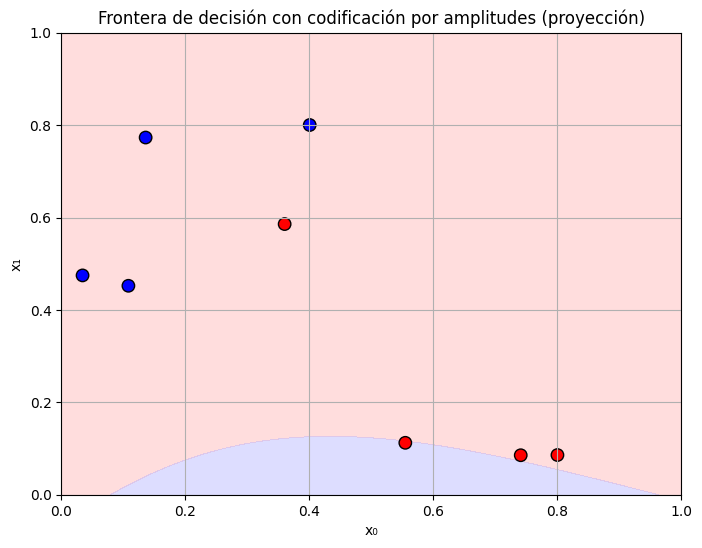

In [6]:
#Prueba de como un clasificador cuántico variacional utiliza codificación por amplitudes (Amplitude Encoding)
#para representar las características de entrada en un estado cuántico. Se analiza el rendimiento sobre un conjunto
#reducido de datos simulados, comparando su capacidad de clasificación y visualizando la frontera de decisión.
#------------------------------------------------------------------------------------------------------------------#
# Importación de bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer

# Generación de datos simulados (moons)
entradas, etiquetas = make_moons(n_samples=100, noise=0.1, random_state=42)

# Normalización al rango [0, 1]
escalador = MinMaxScaler()
entradas_escaladas = escalador.fit_transform(entradas)

# Seleccionamos solo 8 muestras para codificar con amplitudes (3 cúbits → 2^3 = 8 amplitudes)
X_entrenamiento_amp = entradas_escaladas[:8]
y_entrenamiento_amp = etiquetas[:8]
y_entrenamiento_amp_mod = 2 * y_entrenamiento_amp - 1  # Convertimos etiquetas a {-1, +1}

#Expansión de características a 8 dimensiones

def expandir_vector(x):
    return np.array([
        x[0], x[1],
        x[0] * x[1],
        x[0] ** 2, x[1] ** 2,
        np.sin(x[0]), np.sin(x[1]),
        1.0
    ])

#Configuración del circuito cuántico

n_cubits = 3
dispositivo = qml.device("default.qubit", wires=n_cubits)

def codificar_amplitudes(x): #Amplitude Encoding
    x_normalizado = x / np.linalg.norm(x)
    qml.AmplitudeEmbedding(x_normalizado, wires=range(n_cubits), normalize=False)

def ansatz_cuantico(parametros):
    for i in range(n_cubits):
        qml.RY(parametros[0, i], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    for i in range(n_cubits):
        qml.RY(parametros[1, i], wires=i)

@qml.qnode(dispositivo)
def clasificador_cuantico_amplitud(x, parametros):
    codificar_amplitudes(x)
    ansatz_cuantico(parametros)
    return qml.expval(qml.PauliZ(0))

#Entrenamiento del modelo
# Inicialización de parámetros entrenables
parametros = qml.numpy.array(
    np.random.uniform(0, np.pi, size=(2, n_cubits)),
    requires_grad=True
)

optimizador = NesterovMomentumOptimizer(stepsize=0.2)
iteraciones_globales = 30

for iteracion in range(iteraciones_globales):
    for entrada, etiqueta_objetivo in zip(X_entrenamiento_amp, y_entrenamiento_amp_mod):
        x_expandido = expandir_vector(entrada)
        def funcion_perdida(p):
            return (clasificador_cuantico_amplitud(x_expandido, p) - etiqueta_objetivo) ** 2
        parametros = optimizador.step(funcion_perdida, parametros)

    # Precisión en esta iteración
    predicciones = [np.sign(clasificador_cuantico_amplitud(expandir_vector(x), parametros)) for x in X_entrenamiento_amp]
    precision = accuracy_score(y_entrenamiento_amp_mod, predicciones)
    print(f"Iteración {iteracion+1:02d} - Precisión: {precision:.2f}")

#Visualización de la frontera de decisión (proyección)

# Generamos una malla de puntos en el plano (x₀, x₁)
xx, yy = np.meshgrid(
    np.linspace(0, 1, 100),
    np.linspace(0, 1, 100)
)

puntos_malla = np.c_[xx.ravel(), yy.ravel()]

def expandir_malla(X2):
    return np.array([expandir_vector(p) for p in X2])

X_malla_expandida = expandir_malla(puntos_malla)

# Evaluamos el modelo sobre la malla
Z = np.array([clasificador_cuantico_amplitud(x, parametros) for x in X_malla_expandida])
Z = Z.reshape(xx.shape)

# Gráfico de la frontera de decisión
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.4)

# Muestras reales usadas
X_plot = X_entrenamiento_amp[:, :2]
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_entrenamiento_amp, cmap='bwr', edgecolors='k', s=80)

plt.title("Frontera de decisión con codificación por amplitudes (proyección)")
plt.xlabel("x₀")
plt.ylabel("x₁")
plt.grid(True)
plt.show()


Iteración 01 - Precisión: 0.75
Iteración 02 - Precisión: 0.50
Iteración 03 - Precisión: 0.62
Iteración 04 - Precisión: 0.69
Iteración 05 - Precisión: 0.81
Iteración 06 - Precisión: 0.75
Iteración 07 - Precisión: 0.62
Iteración 08 - Precisión: 0.75
Iteración 09 - Precisión: 0.62
Iteración 10 - Precisión: 0.62
Iteración 11 - Precisión: 0.88
Iteración 12 - Precisión: 0.88
Iteración 13 - Precisión: 0.88
Iteración 14 - Precisión: 0.62
Iteración 15 - Precisión: 0.62
Iteración 16 - Precisión: 0.62
Iteración 17 - Precisión: 0.56
Iteración 18 - Precisión: 0.88
Iteración 19 - Precisión: 0.62
Iteración 20 - Precisión: 0.81
Iteración 21 - Precisión: 0.88
Iteración 22 - Precisión: 0.81
Iteración 23 - Precisión: 0.62
Iteración 24 - Precisión: 0.69
Iteración 25 - Precisión: 0.62
Iteración 26 - Precisión: 0.69
Iteración 27 - Precisión: 0.69
Iteración 28 - Precisión: 0.81
Iteración 29 - Precisión: 0.88
Iteración 30 - Precisión: 0.81


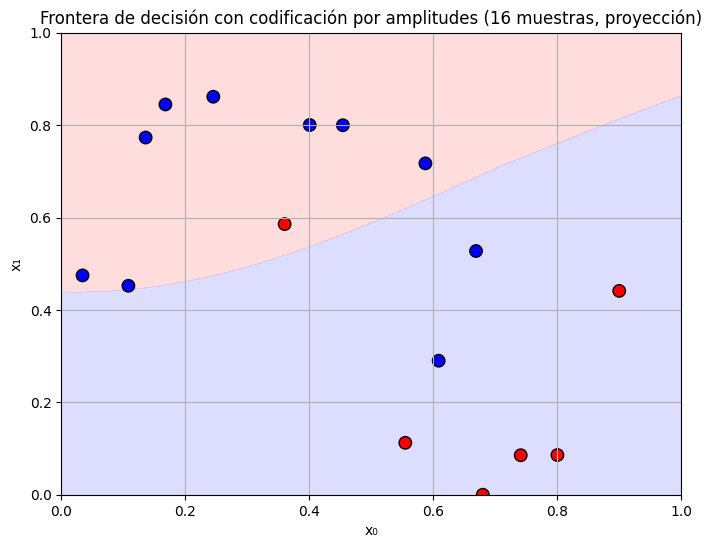

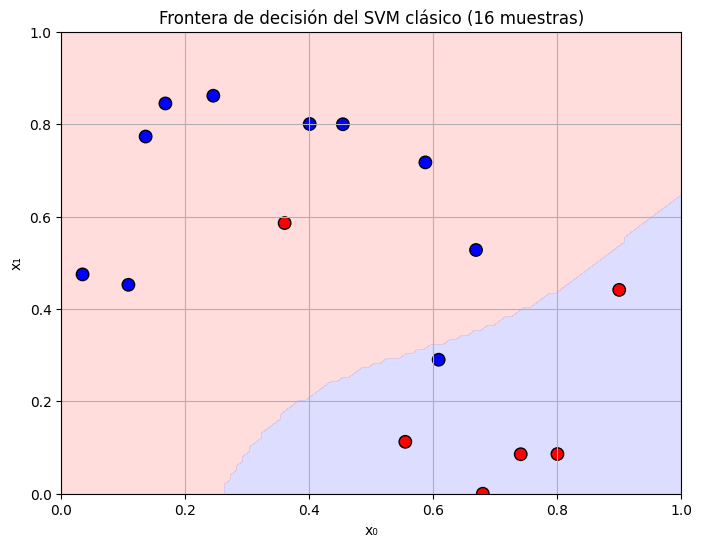

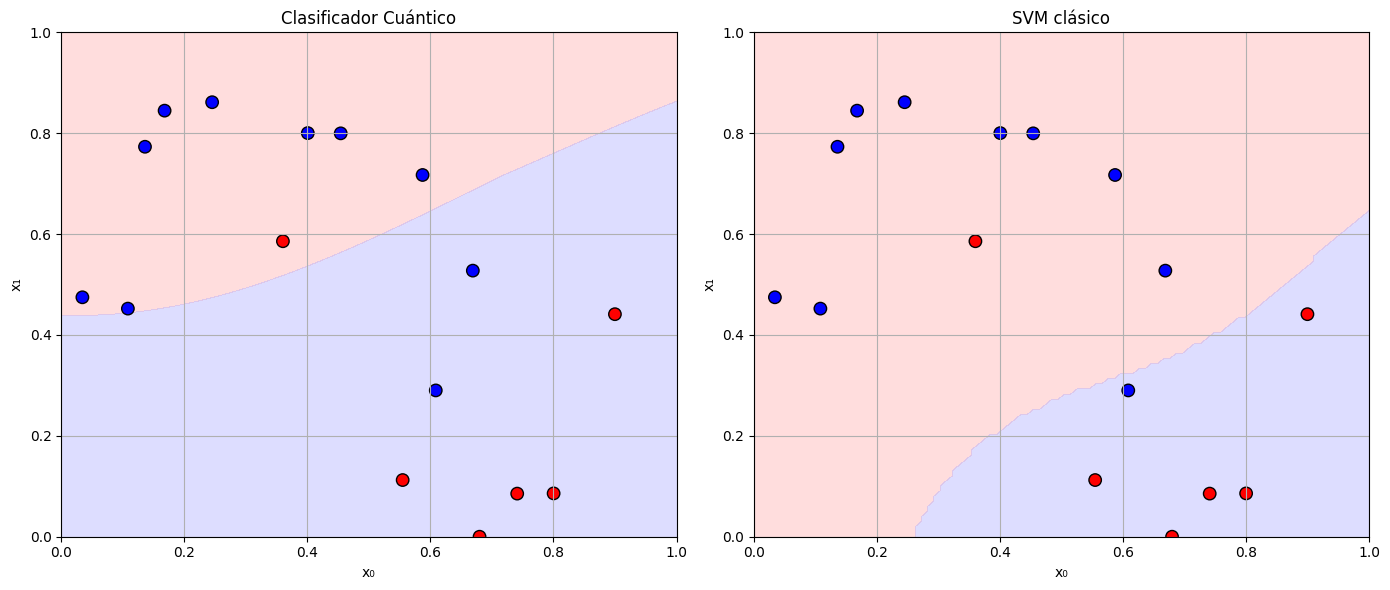


Clasificador Cuántico
  - Precisión: 0.81
  - F1 Score: 0.77
  - Matriz de Confusión:
[[8 2]
 [1 5]]

SVM Clásico
  - Precisión: 0.88
  - F1 Score: 0.83
  - Matriz de Confusión:
[[9 1]
 [1 5]]


In [3]:
#Prueba de comparación de rendimiento de un clasificador cuántico variacional (VQC) (basado en codificación por amplitudes),
#con un modelo clásico de SVM (Support Vector Machine), se utiliza un conjunto reducido de datos no lineales.
#Se incluye el análisis de precisión, visualización de las fronteras de decisión y métricas de evaluación estándar.

# Importación de bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.optimize import NesterovMomentumOptimizer

#...DATOS Y NORMALIZACIÓN...#

# Conjunto de datos "moons"
entradas, etiquetas = make_moons(n_samples=100, noise=0.1, random_state=42)

# Normalizamos al rango [0, 1]
escalador = MinMaxScaler()
entradas_escaladas = escalador.fit_transform(entradas)

# Tomamos las primeras 16 muestras
X_entrenamiento = entradas_escaladas[:16]
y_entrenamiento = etiquetas[:16]
y_entrenamiento_mod = 2 * y_entrenamiento - 1  # Convertimos a {-1, +1}

#...Expansión a 16 características...#

def expandir_entrada(x):
    return np.array([
        x[0], x[1],
        x[0] * x[1],
        x[0] ** 2, x[1] ** 2,
        np.sin(x[0]), np.sin(x[1]),
        np.cos(x[0]), np.cos(x[1]),
        np.exp(-x[0]), np.exp(-x[1]),
        x[0] + x[1],
        abs(x[0] - x[1]),
        x[0] ** 3, x[1] ** 3,
        1.0
    ])

#...CONFIGURACIÓN DEL DISPOSITIVO Y CIRCUITO CUÁNTICO...#

n_cubits = 4
dispositivo = qml.device("default.qubit", wires=n_cubits)

def codificar_amplitudes(x):
    x_normalizado = x / np.linalg.norm(x)
    qml.AmplitudeEmbedding(x_normalizado, wires=range(n_cubits), normalize=False)

def ansatz(parametros):
    n_capas = parametros.shape[0]
    for capa in range(n_capas):
        for i in range(n_cubits):
            qml.RY(parametros[capa, i], wires=i)
            qml.RZ(parametros[capa, i], wires=i)
        for i in range(n_cubits):
            qml.CNOT(wires=[i, (i+1) % n_cubits])

@qml.qnode(dispositivo)
def clasificador_cuantico_amplitud(x, parametros):
    codificar_amplitudes(x)
    ansatz(parametros)
    return qml.expval(qml.PauliZ(0))

#...ENTRENAMIENTO

n_capas = 3
parametros = qml.numpy.array(
    np.random.uniform(0, np.pi, size=(n_capas, n_cubits)),
    requires_grad=True
)

optimizador = NesterovMomentumOptimizer(stepsize=0.2)
iteraciones = 30

for iteracion in range(iteraciones):
    for x, y_objetivo in zip(X_entrenamiento, y_entrenamiento_mod):
        x_expandido = expandir_entrada(x)
        def funcion_perdida(p):
            return (clasificador_cuantico_amplitud(x_expandido, p) - y_objetivo) ** 2
        parametros = optimizador.step(funcion_perdida, parametros)

    predicciones = [np.sign(clasificador_cuantico_amplitud(expandir_entrada(x), parametros)) for x in X_entrenamiento]
    precision = accuracy_score(y_entrenamiento_mod, predicciones)
    print(f"Iteración {iteracion+1:02d} - Precisión: {precision:.2f}")

#...VISUALIZACIÓN DEL CLASIFICADOR CUÁNTICO

xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
puntos_malla = np.c_[xx.ravel(), yy.ravel()]
X_malla_expandida = np.array([expandir_entrada(p) for p in puntos_malla])
Z = np.array([clasificador_cuantico_amplitud(x, parametros) for x in X_malla_expandida])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.4)
plt.scatter(X_entrenamiento[:, 0], X_entrenamiento[:, 1], c=y_entrenamiento, cmap='bwr', edgecolors='k', s=80)
plt.title("Frontera de decisión con codificación por amplitudes (16 muestras, proyección)")
plt.xlabel("x₀")
plt.ylabel("x₁")
plt.grid(True)
plt.show()

#...MODELOS CLÁSICO (SVM)

from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_svm = X_entrenamiento
y_svm = y_entrenamiento

clasificador_svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='auto'))
clasificador_svm.fit(X_svm, y_svm)

xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
puntos_malla = np.c_[xx.ravel(), yy.ravel()]
Z_svm = clasificador_svm.predict(puntos_malla).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_svm, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.4)
plt.scatter(X_svm[:, 0], X_svm[:, 1], c=y_svm, cmap='bwr', edgecolors='k', s=80)
plt.title("Frontera de decisión del SVM clásico (16 muestras)")
plt.xlabel("x₀")
plt.ylabel("x₁")
plt.grid(True)
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(14, 6))

#...COMPARACIÓN VISUAL CUÁNTICO VS SVM

# Clasificador cuántico
Z_q = np.array([clasificador_cuantico_amplitud(expandir_entrada(p), parametros) for p in puntos_malla]).reshape(xx.shape)
axs[0].contourf(xx, yy, Z_q, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.4)
axs[0].scatter(X_entrenamiento[:, 0], X_entrenamiento[:, 1], c=y_entrenamiento, cmap='bwr', edgecolors='k', s=80)
axs[0].set_title("Clasificador Cuántico")
axs[0].set_xlabel("x₀")
axs[0].set_ylabel("x₁")
axs[0].grid(True)

# Clasificador SVM
Z_svm = clasificador_svm.predict(puntos_malla).reshape(xx.shape)
axs[1].contourf(xx, yy, Z_svm, levels=[-1, 0, 1], colors=["#FFAAAA", "#AAAAFF"], alpha=0.4)
axs[1].scatter(X_svm[:, 0], X_svm[:, 1], c=y_svm, cmap='bwr', edgecolors='k', s=80)
axs[1].set_title("SVM clásico")
axs[1].set_xlabel("x₀")
axs[1].set_ylabel("x₁")
axs[1].grid(True)

plt.tight_layout()
plt.show()

#...EVALUACIÓN DE DESEMPEÑO...#

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Predicciones
predicciones_cuantico = [int((clasificador_cuantico_amplitud(expandir_entrada(x), parametros) > 0)) for x in X_entrenamiento]
predicciones_svm = clasificador_svm.predict(X_entrenamiento)

# Función de evaluación
def evaluar_modelo(nombre, y_verdaderas, y_predichas):
    acc = accuracy_score(y_verdaderas, y_predichas)
    f1 = f1_score(y_verdaderas, y_predichas)
    cm = confusion_matrix(y_verdaderas, y_predichas)
    print(f"\n{nombre}")
    print(f"  - Precisión: {acc:.2f}")#Proporción de ejemplos correctamente clasificados sobre el total.

    print(f"  - F1 Score: {f1:.2f}") #Medida del balance entre precisión (precision) y exhaustividad (recall).
              # F1 = 2. (precision.recall) / precision + recall

    print(f"  - Matriz de Confusión:\n{cm}")#Representa los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.
          #[VP  FP]
          #[FN  VN]

          #VP: Verdaderos positivos.
          #VN: Verdaderos Negativos.
          #FP: Falsos Positivos.
          #FN: Falsos Negativos.
# Evaluaciones
evaluar_modelo("Clasificador Cuántico", y_entrenamiento, predicciones_cuantico)
evaluar_modelo("SVM Clásico", y_entrenamiento, predicciones_svm)


**Precisión**

1.   Clasificador Cuántico:
    *   Precisión: 0.81 -> Clasificó correctamente el 81% de las 16 muestras.

2.   SVM Clásico:

    *   Precisión: 0.88 -> Clasificó correctamente el 88% de las muestras.

El SVM Clásico tuvo un mejor desempeño general en clasificación correcta, aunque la diferencia es moderada,

**F1 Score**

1.   Clasificador Cuántico:
    *   F1 Score: 0.67 → Rendimiento medio en la clase minoritaria (positiva).

2.   SVM Clásico:

    *   F1 Score: 0.83 → Muy buen equilibrio entre aciertos y recuperación de la clase positiva.

El SVM Clásico clasificó mejor la clase minoritaria, es posible que se obtuvo más verdaderos positivos que el cuántico.

**Matriz de confusión**

1.   Clasificador Cuántico:
    
    *   10 VP: 10 ejemplos de la clase 0 fueron verdaderos positivos.
    *   0 FP: No hubo falsos positivos (bueno).
    *   3 FN: 3 ejemplos de la clase 1 fueron mal clasificados como 0.
    *   3 VN: Solo 3 ejemplos de la clase 1 fueron detectados correctamente.


2.   SVM Clásico:

    *   9 VP: 9 ejemplos de la clase 0 fueron verdaderos positivos.
    *   1 FP: Hay 1 falso positivo.
    *   1 FN: Un ejemplo de la clase 1 fueran mal clasificados como 0.
    *   5 VN: 5 ejemplos de la clase 1 fueron detectados correctamente.

    
El SVM clásico detectó mejor la clase 1 (mayor VN y menor FN).

El Clasificador cuántico fue más conservador, no cometió falsos positivos (FP) pero dejó pasar varios falsos negativos (más FN).

